In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn
import joblib
import time
from string import punctuation

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, plot_roc_curve, make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
import nltk
from nltk.corpus import stopwords

tqdm.pandas()

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [ ]:
def model_knn():
    """
    Function for initiating Logistic Regression Model
    """

    base_model = KNeighborsClassifier()

    
    return base_model

def model_dt():
    """
    Function for initiating Random Forest Model
    """
    
    base_model = DecisionTreeClassifier(random_state=42)
    
    return base_model

def model_mlp():
    """
    Function for initiating LightGBM Model
    """

    base_model = MLPClassifier(random_state=42, max_iter=300)
    
    return base_model

In [ ]:

def select_model(train_log_dict):
    max_score = max(train_log_dict['model_score'])
    max_index = train_log_dict['model_score'].index(max_score)
    best_model = train_log_dict['model_fit'][max_index]
    name = train_log_dict['model_name'][max_index]

    return best_model, name


In [5]:
def fit(X_train, Y_train, model):

    model_fitted = model.fit(X_train, Y_train)
    return model_fitted

def validate(X_test, Y_test, model_fitted, ):

    auc_score = roc_auc_score(Y_test, model_fitted.predict_proba(X_test))


    return auc_score

In [6]:
def main(X_train, X_test, Y_train,  Y_test):
    

    # Initiate models
    knn = model_knn
    dt = model_dt
    mlp = model_mlp
    
    # Initiate logs
    train_log_dict = {'model': [knn, dt, mlp],
                      'model_name': [],
                      'model_score': []}


    # Try Each models
    for model in train_log_dict['model']:
        base_model = model()
        train_log_dict['model_name'].append(base_model.__class__.__name__)
        print(f'Fitting {base_model.__class__.__name__}')

        # Train
        fitted_model = fit(X_train, Y_train, base_model)

        # Validate
        score = validate(X_test, Y_test, fitted_model)
        train_log_dict['model_score'].append(score)

    best_model, best_report, best_threshold, name = select_model(train_log_dict)
    
    print(
        f"Model: {name}, Score: {best_report['f1-score']['macro avg']}")
    joblib.dump(best_model, 'E:\\projects\\plds_latihan\\pipeline\\mantab_model.pkl')
    joblib.dump(best_threshold, 'E:\\projects\\plds_latihan\\pipeline\\threshold.pkl')
    joblib.dump(train_log_dict, 'E:\\projects\\plds_latihan\\pipeline\\train_log.pkl')
    print(f'\n {best_report}')
    
    return best_model


In [8]:
def load_dataset():

    X_train = joblib.load("E:\\projects\\plds_teamc\\output\\X_train_3.pkl")
    X_test = joblib.load("E:\\projects\\plds_teamc\\output\\X_test_3.pkl")
    Y_train = joblib.load("E:\\projects\\plds_teamc\\output\\Y_train_3.pkl")
    Y_test = joblib.load("E:\\projects\\plds_teamc\\output\\Y_test_3.pkl")

    return X_train, X_test, Y_train,  Y_test

In [17]:
X_train, X_test, Y_train,  Y_test= load_dataset()


In [13]:
!pip install tensorflow

  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached libclang-14.0.1-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached absl_py-1.1.0-py3-none-any.whl (123 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  

In [56]:
!pip install graphviz

In [62]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score
import xgboost as xgb
from xgboost import plot_importance, to_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import graphviz

In [63]:
def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (area = %0.6f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()


def plot_pr(recall,precision,average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: {0:0.6f}'.format(average_precision))
    plt.show()

    
def plot_learning_curve(results,epochs):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='logloss-Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='logloss-Test')
    ax.plot(x_axis, results['validation_0']['auc'], label='auc-Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='auc-Test')
    ax.legend()
    plt.ylabel('Log Loss/AUC')
    plt.title('XGBoost Log Loss and AUC evolution')
    plt.show()


def run_xgboost_and_calculate_auc( X_train, X_test, Y_train, Y_test ,
                                  target='target',
                                  drop='variable_to_find_and_exclude',
                                  w=1,
                                  plot_learning=False,
                                  plot_variables=False,
                                  plot_ROC_PR=False,
                                  plot_confusion=False,
                                  plot_graph_tree=False,
                                  learning_rate=0.05,
                                  max_depth=10,
                                  esr=10,
                                  CV=True,
                                  title='',
                                  plot_all=False,
                                  ensembler=False,
                                  test_size=.2):
    '''
    Generic function to run xgboost to test the added changes and plot roc, learning and others and save the model.
    '''
   
        
    clf = xgb.XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=4,
        gamma=0.6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=5e-05,
        objective='binary:logistic',
        nthread=20,
        scale_pos_weight=w,
        seed=27)

    eval_set = [(X_train, Y_train), (X_test, Y_test)]

    if plot_all:
        plot_learning=True
        plot_variables=True
        plot_ROC_PR=True
        plot_confusion=True
        plot_graph_tree=True
        
    if CV:
        X = pd.concat([X_train,X_test])
        y = pd.concat([Y_train,Y_test])
        xgb_param = clf.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, y.values)
        cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round=clf.get_params()['n_estimators'],
                          nfold=5,
                          metrics='auc',
                          early_stopping_rounds=esr)
        print(cvresult.tail(1))
        clf.set_params(n_estimators=cvresult.shape[0])

    clf.fit(X_train,
            Y_train,
            early_stopping_rounds=25,
            eval_metric=['auc','error','logloss'],
            eval_set=eval_set,
            verbose=False)

    Y_pred = clf.predict_proba(X_test)
    y_true = np.array(Y_test)
    y_scores = Y_pred[:, 1]

    fpr, tpr, _ = roc_curve(Y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(Y_test, y_scores)
    precision, recall, _ = precision_recall_curve(Y_test, y_scores)
    
    if plot_ROC_PR:
        plot_roc(fpr, tpr, roc_auc)
        plot_pr(recall,precision,average_precision)
    else:
        print('Area under ROC: %0.6f' % roc_auc)

    if plot_graph_tree:
        xgb.plot_tree(clf, rankdir='LR')
        fig = plt.gcf()
        fig.set_size_inches(150, 100)

    if plot_learning:
        results = clf.evals_result()
        epochs = len(results['validation_0']['error'])

    if plot_variables:
        xgb.plot_importance(clf,max_num_features=20,importance_type='gain',xlabel='gain')

    if plot_confusion:
        print('\n', classification_report(y_true, y_scores.round()))

    if title:
        timestr = time.strftime("%Y%m%d-%H%M%S")
        path = 'E:\\projects\\plds_teamc\\model\\xgb'
        save_model(model=clf,path=path,title=str(title))
        
    if ensembler:
        return Y_test, y_scores

    print('-------------END EXECUTION-------------')

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
207        0.742907        0.00051       0.741541      0.001995


c:\Users\mhpra\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\mhpra\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


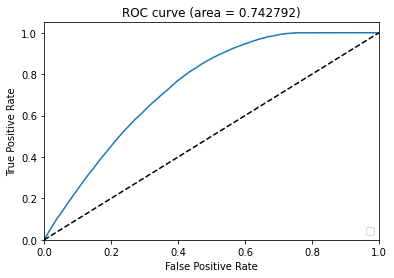

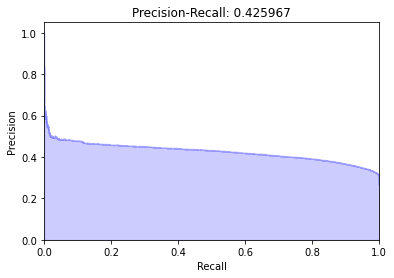

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

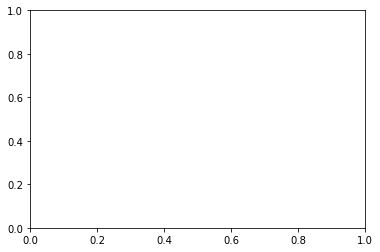

In [65]:

Y_test, y_scores = run_xgboost_and_calculate_auc(  X_train, X_test, Y_train, Y_test ,target='Survived',plot_all=True,ensembler=True)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [49]:
# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization
import tensorflow.keras.models as models
import tensorflow.keras.callbacks
from tensorflow.keras.layers import BatchNormalization, Dropout

from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.initializers import Constant

model = models.Sequential()
#model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(Dense(16, name="dense1", kernel_initializer="he_normal"))
model.add(Dense(32, name="dense2", kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(64, name="dense3", kernel_initializer="he_normal"))
model.add(Dense(128, name="dense4", kernel_initializer="he_normal"))
model.add(BatchNormalization())
model.add(Dense(512, name="dense5", kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(128, name="dense6", kernel_initializer="he_normal"))
model.add(Dense(64, name="dense7", kernel_initializer="he_normal"))
model.add(Dropout(0.1))
model.add(Dense(32, name="dense8", kernel_initializer="he_normal"))
model.add(Dense(16, name="dense9", kernel_initializer="he_normal"))
model.add(Dense(1, name="dense10", kernel_initializer="he_normal", activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])




In [15]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

ValueError: could not convert string to float: '> 50'

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227262 entries, 110780 to 176986
Data columns (total 23 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   Patient Age at Treatment                                        227262 non-null  int64  
 1   Total Number of Previous treatments, Both IVF and DI at clinic  227262 non-null  int64  
 2   Total Number of Previous IVF cycles                             227262 non-null  int64  
 3   Total number of IVF pregnancies                                 227262 non-null  int64  
 4   Type of Infertility - Female Primary                            227262 non-null  int64  
 5   Type of Infertility - Female Secondary                          227262 non-null  int64  
 6   Type of Infertility - Male Primary                              227262 non-null  int64  
 7   Type of Infertility - Male Second

In [50]:
nb_epoch = 100     # number of epochs to train on
batch_size = 1024 # training batch size
filepath = 'E:\\projects\\plds_teamc\\data\\HARRY.h5'

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test,Y_test),
    shuffle=True)


# convert the history.history dict to a pandas DataFrame:   
# #https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object  
hist_df = pd.DataFrame(history.history) 
hist_csv_file = 'E:\\projects\\plds_teamc\\data\\history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/100
222/222 - 6s - loss: 0.8200 - accuracy: 0.6987 - val_loss: 0.5221 - val_accuracy: 0.7397 - 6s/epoch - 28ms/step
Epoch 2/100
222/222 - 4s - loss: 0.5308 - accuracy: 0.7376 - val_loss: 0.5122 - val_accuracy: 0.7416 - 4s/epoch - 20ms/step
Epoch 3/100
222/222 - 4s - loss: 0.5221 - accuracy: 0.7381 - val_loss: 0.5093 - val_accuracy: 0.7438 - 4s/epoch - 19ms/step
Epoch 4/100
222/222 - 4s - loss: 0.5190 - accuracy: 0.7388 - val_loss: 0.5086 - val_accuracy: 0.7419 - 4s/epoch - 19ms/step
Epoch 5/100
222/222 - 4s - loss: 0.5179 - accuracy: 0.7394 - val_loss: 0.5085 - val_accuracy: 0.7423 - 4s/epoch - 19ms/step
Epoch 6/100
222/222 - 4s - loss: 0.5164 - accuracy: 0.7393 - val_loss: 0.5110 - val_accuracy: 0.7452 - 4s/epoch - 19ms/step
Epoch 7/100
222/222 - 4s - loss: 0.5158 - accuracy: 0.7393 - val_loss: 0.5091 - val_accuracy: 0.7449 - 4s/epoch - 19ms/step
Epoch 8/100
222/222 - 4s - loss: 0.5150 - accuracy: 0.7400 - val_loss: 0.5083 - val_accuracy: 0.7397 - 4s/epoch - 19ms/step
Epoch 9/

In [20]:
acc_threshold = hist_df["accuracy"].mean()
joblib.dump(acc_threshold, 'E:\\projects\\plds_teamc\\data\\acc_threshold.pkl')

['E:\\projects\\plds_teamc\\data\\acc_threshold.pkl']

In [ ]:
base_model = KNeighborsClassifier(n_neighbors=50)
#base_model = DecisionTreeClassifier(random_state=42)

#base_model = MLPClassifier(hidden_layer_sizes=(100,300,150), random_state=42, max_iter=300)


model_fitted = base_model.fit(X_train, Y_train)

#auc_score = roc_auc_score(Y_test, model_fitted.predict(X_test))
auc_score = roc_auc_score(Y_test, model_fitted.predict(X_test))



In [31]:
X_train, X_test, Y_train,  Y_test= load_dataset()
text=X_train.iloc[1000]
text.to_csv('E:\projects\plds_teamc\data\sample2.csv')  
text

Patient Age at Treatment                                          0.0
Total Number of Previous treatments, Both IVF and DI at clinic    0.0
Total Number of Previous IVF cycles                               0.0
Total number of IVF pregnancies                                   0.0
Type of Infertility - Female Primary                              0.0
Type of Infertility - Female Secondary                            0.0
Type of Infertility - Male Primary                                0.0
Type of Infertility - Male Secondary                              0.0
Type of Infertility -Couple Primary                               0.0
Type of Infertility -Couple Secondary                             0.0
Cause  of Infertility - Tubal disease                             0.0
Cause of Infertility - Ovulatory Disorder                         0.0
Cause of Infertility - Male Factor                                1.0
Cause of Infertility - Patient Unexplained                        0.0
Cause of Infertility

In [22]:
#joblib.dump(model, 'E:\\projects\\plds_teamc\\data\\mantab_model.pkl')
model.save('E:\\projects\\plds_teamc\\data\\')

INFO:tensorflow:Assets written to: E:\projects\plds_teamc\data\assets


In [45]:
def main_predict(text, model, threshold):
    text = text[[text.columns[1]]]
    text = np.asarray(text).astype(np.float32).T
    text = text.reshape(-1, 23)
    code2rel = {0: 'Tidak berhasil', 1: 'Berhasil'}
    
    proba = model.predict(text)
    predict = 1 if proba > threshold else 0
    print(f"{code2rel[predict]}, dengan akurasi {proba}")

    return code2rel[predict], proba


    

In [44]:
model = models.load_model('E:\\projects\\plds_teamc\\data\\')
#threshold = joblib.load('E:\\projects\\plds_teamc\\data\\acc_threshold.pkl')

In [46]:
text = pd.read_csv("E:\projects\plds_teamc\data\sample2.csv") 
#text = np.asarray(text).astype(np.float32)


In [47]:
threshold = 0.741541
proba = main_predict(text, model, threshold)

1/1 [==============================] - 0s 133ms/step
Tidak berhasil, dengan akurasi [[0.3675122]]
